In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import Weibo2014
from moabb.datasets import Zhou2016
from moabb.datasets import BNCI2014004
from moabb.datasets import BNCI2014002
from moabb.datasets import BNCI2015001
from moabb.datasets import AlexMI

from moabb.evaluations import WithinSessionEvaluation
from moabb.evaluations import CrossSessionEvaluation


import mne
from mne.preprocessing import Xdawn
from mne.decoding import CSP


from moabb.paradigms import MotorImagery
from pyriemann.estimation import Covariances
from pyriemann.utils.covariance import covariances
from pyriemann.estimation import ERPCovariances
from pyriemann.estimation import XdawnCovariances
from pyriemann.classification import MDM
from pyriemann.classification import KNearestNeighbor
from pyriemann.tangentspace import TangentSpace
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC






moabb.set_log_level("info")
warnings.filterwarnings("ignore")

In [2]:
paradigm = MotorImagery()
paradigm_name = 'MI'

2022-06-01 14:11:41,729 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


In [5]:
pipelines = {}
pipelines["(1) epo-mdm-euc"] = make_pipeline(MDM(metric="euclid"))
#pipelines["(2) epo-knn-euc"] = make_pipeline(KNearestNeighbor(), MDM(metric="euclid"))
# #default 5 neighbors
#pipelines["(3) cov-dia-lda"] = make_pipeline(Covariances(), _sch), LDA())
# #sch for schaffer
pipelines["(4) epo-csp-lda"] = make_pipeline(CSP(), LDA())
#pipelines["(5) cov-knn-euc"] = make_pipeline(Covariances(), KNearestNeighbor(metric="euclid"))
# # pipelines["(6) cov-knn-rie"] = make_pipeline(Covariances(), KNearestNeighbor())
# # #default riemannian
pipelines["(7) cov-mdm-euc"] = make_pipeline(Covariances(), MDM(metric="euclid"))
# # pipelines["(8) cov-mdm-rie"] = make_pipeline(Covariances(), MDM())
#pipelines["(9) cov-tgs-lda"] = make_pipeline(Covariances(), TangentSpace(), LDA())
# # #(default: 'riemann')



In [6]:
datasets = [Weibo2014(), Zhou2016(), BNCI2014004(), BNCI2014002(), BNCI2015001(),AlexMI()]
subj = [1, 2, 3 ,4]
for d in datasets:
    d.subject_list = subj
paradigm = paradigm
evaluation = CrossSessionEvaluation(
    paradigm=paradigm, datasets=datasets, suffix="examples", overwrite=False
)
results = evaluation.process(pipelines)

2022-06-01 14:11:52,329 WARNING MainThread moabb.evaluations.base <moabb.datasets.Weibo2014.Weibo2014 object at 0x7f57f4fab520> not compatible with evaluation. Removing this dataset from the list.
2022-06-01 14:11:52,332 WARNING MainThread moabb.evaluations.base <moabb.datasets.bnci.BNCI2014002 object at 0x7f5828a4e190> not compatible with evaluation. Removing this dataset from the list.
2022-06-01 14:11:52,338 WARNING MainThread moabb.evaluations.base <moabb.datasets.alex_mi.AlexMI object at 0x7f5828a4e400> not compatible with evaluation. Removing this dataset from the list.
2022-06-01 14:11:52,341 INFO MainThread moabb.evaluations.base Processing dataset: Zhou 2016
Zhou 2016-CrossSession: 100%|██████████| 4/4 [00:00<00:00, 96.34it/s]
2022-06-01 14:11:52,391 INFO MainThread moabb.evaluations.base Processing dataset: 004-2014
004-2014-CrossSession: 100%|██████████| 4/4 [00:00<00:00, 61.64it/s]
2022-06-01 14:11:52,464 INFO MainThread moabb.evaluations.base Processing dataset: 001-2015
0

In [7]:
results.to_csv("./results_part2-1.csv")

In [8]:
results = pd.read_csv("./results_part2-1.csv")

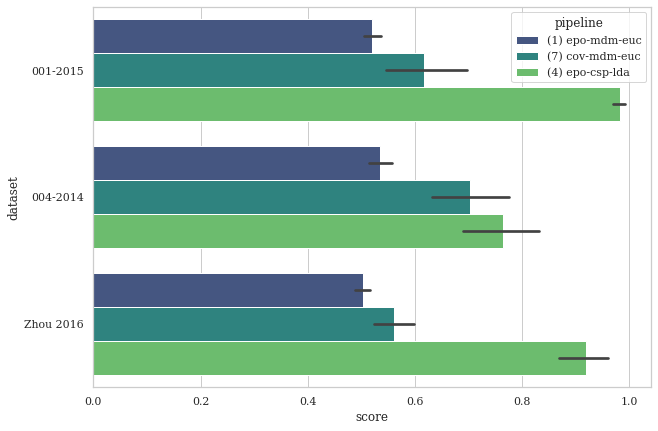

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))
results["dataset"] = results["dataset"].apply(str)
sns.barplot(
    x="score", y="dataset", hue="pipeline", data=results, orient="h", palette="viridis", ax=ax
)
fig.show()